In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
BASE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification"
SPEC_DIR = "/tmp/dataset/hms-hbac"
os.makedirs(SPEC_DIR+'/train_spectrograms', exist_ok=True)
os.makedirs(SPEC_DIR+'/test_spectrograms', exist_ok=True) 

In [3]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    image_size = [400, 300]  # Input image size
    num_classes = 6 # Number of classes in the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
    label2name = dict(enumerate(class_names))
    name2label = {v:k for k, v in label2name.items()}

In [4]:
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['eeg_path'] = f'{BASE_PATH}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['spec2_path'] = f'{SPEC_DIR}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.npy'
df['class_name'] = df.expert_consensus.copy()
df['class_label'] = df.expert_consensus.map(CFG.name2label)
print(len(df))
display(df.head())

106800


eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   
2  1628180742           2                       8.0          353733   
3  1628180742           3                      18.0          353733   
4  1628180742           4                      24.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   
2                   2                               8.0  1142670488   
3                   3                              18.0  2718991173   
4                   4                              24.0  3080632009   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0          0   
1       42516          Seizure             3         0         0          0   
2       42516          Seizure             3         0         0          0   
3       42516          Seizure             3         0         0          0   
4       42516          Seizure             3         0         0          0   

   grda_vote  other_vote                                           eeg_path  \
0          0           0  /kaggle/input/hms-harmful-brain-activity-class...   
1          0           0  /kaggle/input/hms-harmful-brain-activity-class...   
2          0           0  /kaggle/input/hms-harmful-brain-activity-class...   
3          0           0  /kaggle/input/hms-harmful-brain-activity-class...   
4          0           0  /kaggle/input/hms-harmful-brain-activity-class...   

                                           spec_path  \
0  /kaggle/input/hms-harmful-brain-activity-class...   
1  /kaggle/input/hms-harmful-brain-activity-class...   
2  /kaggle/input/hms-harmful-brain-activity-class...   
3  /kaggle/input/hms-harmful-brain-activity-class...   
4  /kaggle/input/hms-harmful-brain-activity-class...   

                                          spec2_path class_name  class_label  
0  /tmp/dataset/hms-hbac/train_spectrograms/35373...    Seizure            0  
1  /tmp/dataset/hms-hbac/train_spectrograms/35373...    Seizure            0  
2  /tmp/dataset/hms-hbac/train_spectrograms/35373...    Seizure            0  
3  /tmp/dataset/hms-hbac/train_spectrograms/35373...    Seizure            0  
4  /tmp/dataset/hms-hbac/train_spectrograms/35373...    Seizure            0

In [5]:
import pandas as pd

# Grouping and aggregating data
train = df.groupby('eeg_id').agg(
    spec_id=('spectrogram_id', 'first'),
    min_offset=('spectrogram_label_offset_seconds', 'min'),
    max_offset=('spectrogram_label_offset_seconds', 'max'),
    patient_id=('patient_id', 'first'),
    expert_consensus=('expert_consensus', 'first'),
    seizure_vote=('seizure_vote', 'sum'),
    lpd_vote=('lpd_vote', 'sum'),
    gpd_vote=('gpd_vote', 'sum'),
    lrda_vote=('lrda_vote', 'sum'),
    grda_vote=('grda_vote', 'sum'),
    other_vote=('other_vote', 'sum')
).reset_index()

# Normalizing target variables
TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
train[TARGETS] = train[TARGETS].div(train[TARGETS].sum(axis=1), axis=0)

print('Train non-overlapping eeg_id shape:', train.shape)

Train non-overlapping eeg_id shape: (17089, 12)


In [6]:
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


eeg_id     spec_id     min     max  patient_id  seizure_vote  lpd_vote  \
0  568657   789577333     0.0    16.0       20654           0.0  0.000000   
1  582999  1552638400     0.0    38.0       20230           0.0  0.857143   
2  642382    14960202  1008.0  1032.0        5955           0.0  0.000000   
3  751790   618728447   908.0   908.0       38549           0.0  0.000000   
4  778705    52296320     0.0     0.0       40955           0.0  0.000000   

   gpd_vote  lrda_vote  grda_vote  other_vote target  
0      0.25   0.000000   0.166667    0.583333  Other  
1      0.00   0.071429   0.000000    0.071429    LPD  
2      0.00   0.000000   0.000000    1.000000  Other  
3      1.00   0.000000   0.000000    0.000000    GPD  
4      0.00   0.000000   0.000000    1.000000  Other

In [7]:
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
spectrograms = {}
for i, f in enumerate(files):
    if i % 100 == 0:
        print(i, ', ', end='')
    tmp = pd.read_parquet(f'{PATH}{f}')
    name = int(f.split('.')[0])
    spectrograms[name] = tmp.iloc[:, 1:].values

0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 

In [8]:
all_eegs = np.load('/kaggle/input/brain-eeg-spectrograms/eeg_specs.npy',allow_pickle=True).item()

In [17]:
!pip download efficientnet

  File was already downloaded /kaggle/working/efficientnet-1.1.1-py3-none-any.whl
  File was already downloaded /kaggle/working/Keras_Applications-1.0.8-py3-none-any.whl
  File was already downloaded /kaggle/working/scikit_image-0.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  File was already downloaded /kaggle/working/numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  File was already downloaded /kaggle/working/h5py-3.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  File was already downloaded /kaggle/working/scipy-1.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  File was already downloaded /kaggle/working/networkx-3.2.1-py3-none-any.whl
  File was already downloaded /kaggle/working/pillow-10.2.0-cp310-cp310-manylinux_2_28_x86_64.whl
  File was already downloaded /kaggle/working/imageio-2.34.0-py3-none-any.whl
  File was already downloaded /kaggle/working/tifffile-2024.2.12-py3-none-any.whl
  File was alrea

In [11]:
import albumentations as albu
import tensorflow as tf

# Dictionary mapping target labels to numerical values
TARS = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}

# Dictionary mapping numerical values to target labels
TARS2 = {x: y for y, x in TARS.items()}

class DataGenerator(tf.keras.utils.Sequence):
    """
    Custom data generator for Keras.
    Generates data batches for training or evaluation.
    """
    def __init__(self, data, batch_size=32, shuffle=False, mode='train',
                 specs=spectrograms, eeg_specs=all_eegs): 
        """
        Initialize the generator.

        Args:
            data (DataFrame): Data containing information about spectrogram slices.
            batch_size (int): Batch size.
            shuffle (bool): Whether to shuffle the data.
            mode (str): 'train' or 'test' mode.
            specs (dict): Dictionary containing spectrogram data.
            eeg_specs (dict): Dictionary containing EEG spectrogram data.
        """
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mode = mode
        self.specs = specs
        self.eeg_specs = eeg_specs
        self.on_epoch_end()
        
    def __len__(self):
        """
        Denotes the number of batches per epoch.
        """
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data.

        Args:
            index (int): Batch index.

        Returns:
            X (numpy.ndarray): Input data batch.
            y (numpy.ndarray): Target data batch.
        """
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        """
        Updates indexes after each epoch.
        Shuffles the data if shuffle is enabled.
        """
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)
                        
    def __data_generation(self, indexes):
        """
        Generates data containing batch_size samples.

        Args:
            indexes (numpy.ndarray): Indexes of samples in the batch.

        Returns:
            X (numpy.ndarray): Input data batch.
            y (numpy.ndarray): Target data batch.
        """
        X = np.zeros((len(indexes), 128, 256, 8), dtype='float32')
        y = np.zeros((len(indexes), 6), dtype='float32')
        
        for j, i in enumerate(indexes):
            row = self.data.iloc[i]
            if self.mode == 'test': 
                r = 0
            else: 
                r = int((row['min'] + row['max']) // 4)

            for k in range(4):
                # Extract 300 rows of spectrogram
                img = self.specs[row.spec_id][r:r+300, k*100:(k+1)*100].T
                
                # Log transform spectrogram
                img = np.clip(img, np.exp(-4), np.exp(8))
                img = np.log(img)
                
                # Standardize per image
                ep = 1e-6
                m = np.nanmean(img.flatten())
                s = np.nanstd(img.flatten())
                img = (img - m) / (s + ep)
                img = np.nan_to_num(img, nan=0.0)
                
                # Crop to 256 time steps
                X[j, 14:-14, :, k] = img[:, 22:-22] / 2.0
        
            # EEG spectrograms
            img = self.eeg_specs[row.eeg_id]
            X[j, :, :, 4:] = img
                
            if self.mode != 'test':
                y[j, :] = row[TARGETS]
            
        return X, y

2024-03-24 16:33:30.307622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 16:33:30.307734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 16:33:30.471494: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


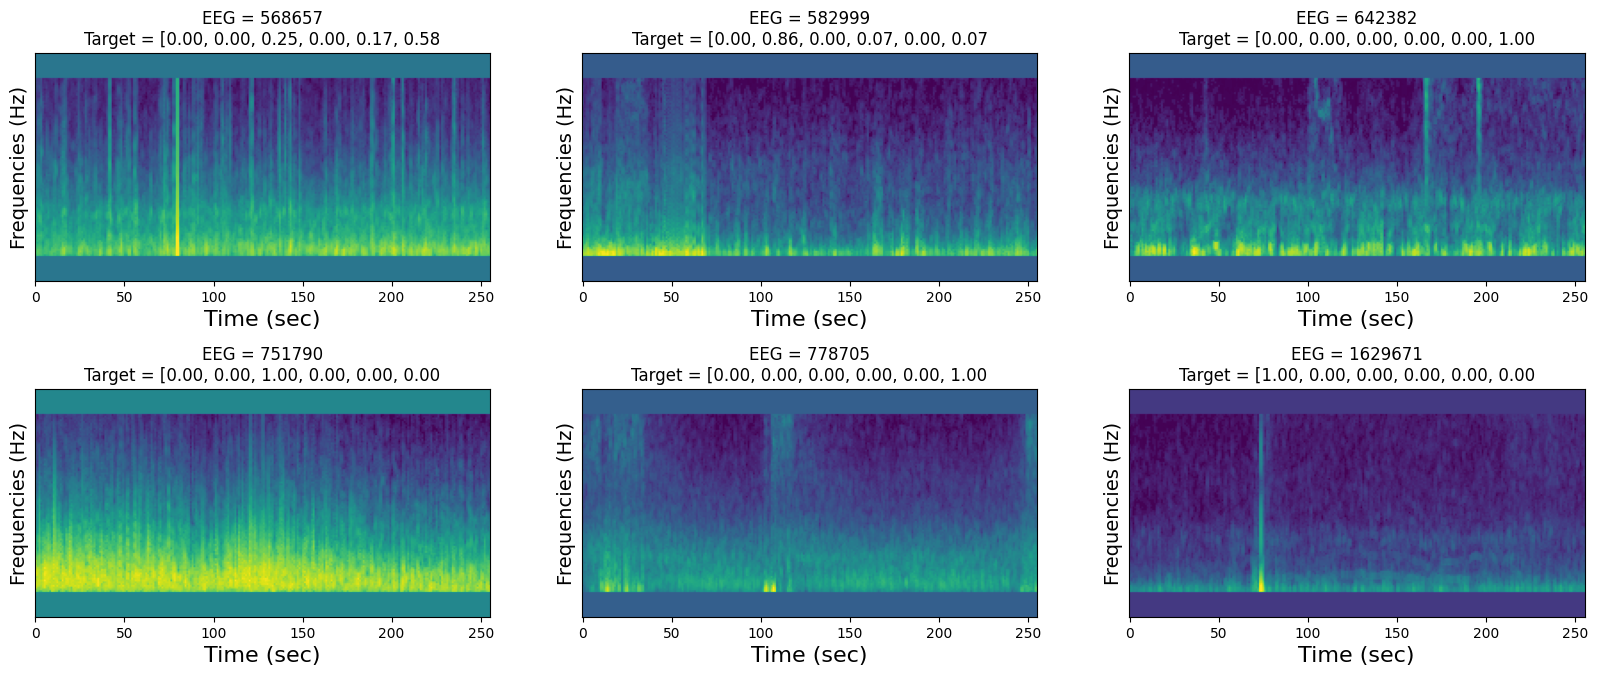

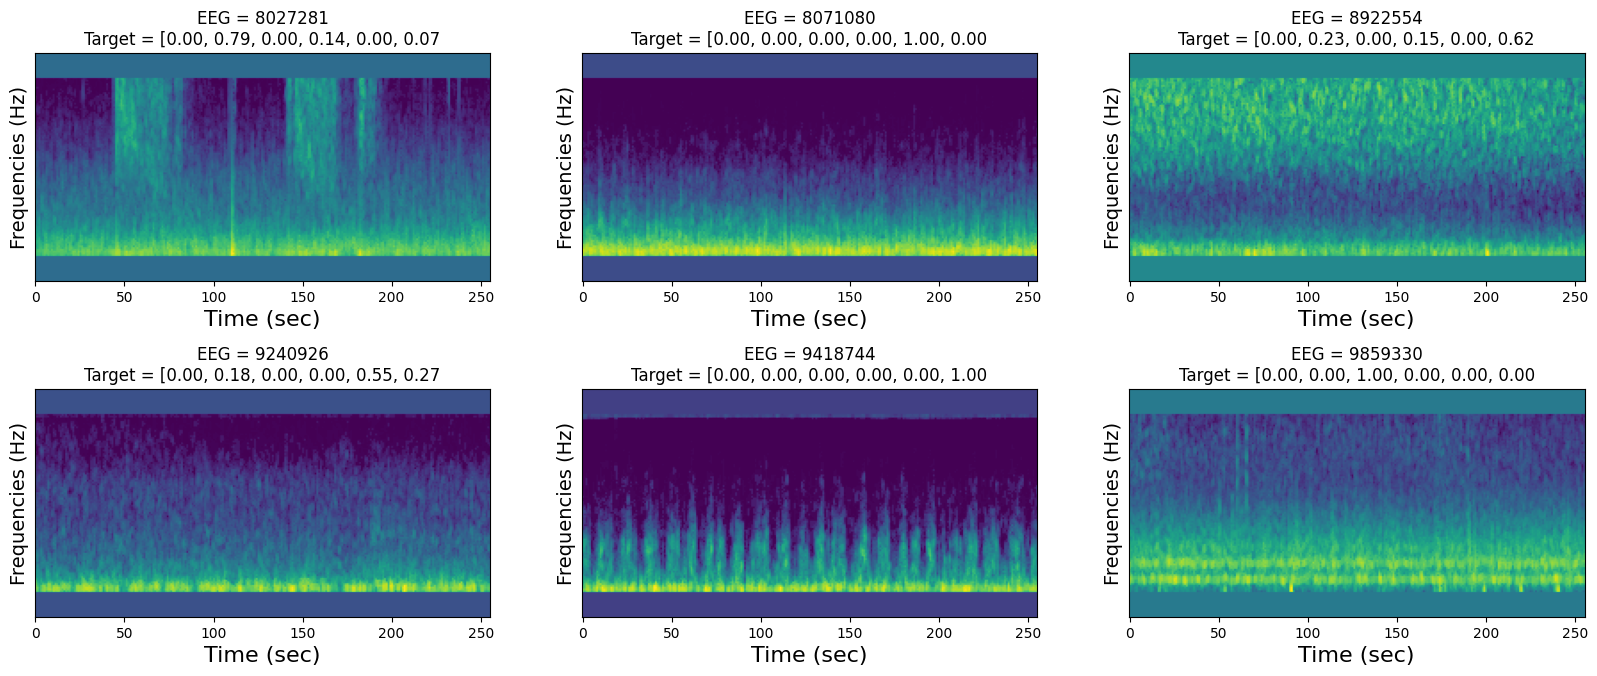

In [13]:
ROWS = 2  # Number of rows in each plot
COLS = 3  # Number of columns in each plot
BATCHES = 2  # Number of batches to generate

# Create an instance of the DataGenerator
gen = DataGenerator(train, batch_size=32, shuffle=False)

# Loop over batches generated by the DataGenerator
for i, (x, y) in enumerate(gen):
    plt.figure(figsize=(20, 8))
    
    # Iterate over rows in the plot
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j * COLS + k + 1)
            # Extract target and image for each subplot
            t = y[j * COLS + k]
            img = x[j * COLS + k, :, :, 0][::-1, ]  # Reversed for correct orientation
            mn = img.flatten().min()
            mx = img.flatten().max()
            img = (img - mn) / (mx - mn)  # Normalize image
            plt.imshow(img)
            
            # Format target values
            tars = f'[{t[0]:0.2f}'
            for s in t[1:]:
                tars += f', {s:0.2f}'
            
            # Get EEG ID
            eeg = train.eeg_id.values[i * 32 + j * COLS + k]
            
            # Set title and labels
            plt.title(f'EEG = {eeg}\nTarget = {tars}', size=12)
            plt.yticks([])
            plt.ylabel('Frequencies (Hz)', size=14)
            plt.xlabel('Time (sec)', size=16)
    
    plt.show()
    if i == BATCHES - 1:
        break  # Exit loop after specified number of batches

In [19]:
!pip install --no-index --find-links=/kaggle/working/ /kaggle/working/efficientnet-1.1.1-py3-none-any.whl

Looking in links: /kaggle/working/
Processing ./efficientnet-1.1.1-py3-none-any.whl
Processing ./Keras_Applications-1.0.8-py3-none-any.whl (from efficientnet==1.1.1)


In [29]:
import efficientnet.tfkeras as efn
from sklearn.model_selection import GroupKFold
import tensorflow.keras.backend as K
import gc
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the step-wise learning rate schedule
def lr_schedule(epoch):
    if epoch < 2:
        return 1e-3
    elif epoch < 4:
        return 1e-4
    else:
        return 1e-5

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

USE_KAGGLE_SPECTROGRAMS=True
USE_EEG_SPECTROGRAMS=True
EPOCHS=1
def build_model():
    inp = tf.keras.Input(shape=(128, 256, 8))
    base_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=None)
    base_model.load_weights('/kaggle/input/tf-efficientnet-imagenet-weights/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5')
    
    # RESHAPE INPUT 128x256x8 => 512x512x3 MONOTONE IMAGE
    # KAGGLE SPECTROGRAMS
    x1 = [inp[:, :, :, i:i+1] for i in range(4)]
    x1 = tf.keras.layers.Concatenate(axis=1)(x1)
    # EEG SPECTROGRAMS
    x2 = [inp[:, :, :, i+4:i+5] for i in range(4)]
    x2 = tf.keras.layers.Concatenate(axis=1)(x2)
    # MAKE 512X512X3
    if USE_KAGGLE_SPECTROGRAMS & USE_EEG_SPECTROGRAMS:
        x = tf.keras.layers.Concatenate(axis=2)([x1, x2])
    elif USE_EEG_SPECTROGRAMS:
        x = x2
    else:
        x = x1
    x = tf.keras.layers.Concatenate(axis=3)([x, x, x])
    
    # OUTPUT
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(6, activation='softmax', dtype='float32')(x)
        
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    loss = tf.keras.losses.KLDivergence()

    model.compile(loss=loss, optimizer=opt) 
        
    return model

all_oof = []
all_true = []

In [30]:
gkf = GroupKFold(n_splits=5)
VER=0
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):  
    
    print('#' * 25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(train.iloc[train_index], shuffle=True, batch_size=32)
    valid_gen = DataGenerator(train.iloc[valid_index], shuffle=False, batch_size=64, mode='valid')
    
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#' * 25)
    
    K.clear_session()
    model = build_model()
    model.fit(train_gen, verbose=1,
              validation_data=valid_gen,
              epochs=EPOCHS, callbacks=[lr_scheduler])
    model.save_weights(f'EffNet_v{VER}_f{i}.weights.h5')
        
    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(train.iloc[valid_index][TARGETS].values)
    
    del model, oof
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711301558.652527     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


161/428 ━━━━━━━━━━━━━━━━━━━━ 3:33 801ms/step - loss: 0.8764

W0000 00:00:1711301687.258608     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - loss: 0.7745

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711301843.676123     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


428/428 ━━━━━━━━━━━━━━━━━━━━ 383s 719ms/step - loss: 0.7742 - val_loss: 0.7990 - learning_rate: 0.0010


W0000 00:00:1711301865.890032     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 1/54 ━━━━━━━━━━━━━━━━━━━━ 5:31 6s/step

W0000 00:00:1711301907.921843     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 552ms/step


W0000 00:00:1711301937.163665     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


#########################
### Fold 2
### train size 13671, valid size 3418
#########################


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711302019.582761     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 11/428 ━━━━━━━━━━━━━━━━━━━━ 30:16 4s/step - loss: 1.2775  

W0000 00:00:1711302063.520865     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - loss: 0.8116

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711302304.202677     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


428/428 ━━━━━━━━━━━━━━━━━━━━ 386s 718ms/step - loss: 0.8114 - val_loss: 0.7727 - learning_rate: 0.0010


W0000 00:00:1711302326.637922     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 1/54 ━━━━━━━━━━━━━━━━━━━━ 4:55 6s/step

W0000 00:00:1711302333.426156     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 530ms/step


W0000 00:00:1711302361.496627     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


#########################
### Fold 3
### train size 13671, valid size 3418
#########################


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711302442.832661     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


392/428 ━━━━━━━━━━━━━━━━━━━━ 23s 659ms/step - loss: 0.8257

W0000 00:00:1711302700.775721     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - loss: 0.8149

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711302726.885897     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


428/428 ━━━━━━━━━━━━━━━━━━━━ 385s 717ms/step - loss: 0.8147 - val_loss: 0.7915 - learning_rate: 0.0010


W0000 00:00:1711302749.261267     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 1/54 ━━━━━━━━━━━━━━━━━━━━ 4:50 5s/step

W0000 00:00:1711302756.027887     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 484ms/step


W0000 00:00:1711302781.674640     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


#########################
### Fold 4
### train size 13671, valid size 3418
#########################


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711302863.676087     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/428 ━━━━━━━━━━━━━━━━━━━━ 3:27 795ms/step - loss: 0.8977

W0000 00:00:1711302996.029264     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - loss: 0.7912

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711303149.189120     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


428/428 ━━━━━━━━━━━━━━━━━━━━ 387s 720ms/step - loss: 0.7910 - val_loss: 0.8773 - learning_rate: 0.0010


W0000 00:00:1711303171.717667     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 1/54 ━━━━━━━━━━━━━━━━━━━━ 4:56 6s/step

W0000 00:00:1711303178.493444     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 511ms/step


W0000 00:00:1711303205.565440     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


#########################
### Fold 5
### train size 13672, valid size 3417
#########################


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711303291.225103     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 18/428 ━━━━━━━━━━━━━━━━━━━━ 30:29 4s/step - loss: 1.1414  

W0000 00:00:1711303367.423019     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - loss: 0.8020

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711303604.261827     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


428/428 ━━━━━━━━━━━━━━━━━━━━ 436s 826ms/step - loss: 0.8017 - val_loss: 0.7829 - learning_rate: 0.0010


W0000 00:00:1711303644.302186     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 1/54 ━━━━━━━━━━━━━━━━━━━━ 5:03 6s/step

W0000 00:00:1711303651.174997     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 538ms/step


W0000 00:00:1711303679.704683     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [31]:
import cv2

def mask2contour(mask, width=5):
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3) 

clahe = cv2.createCLAHE(clipLimit=16.0, tileGridSize=(8,8))

In [43]:
import efficientnet.tfkeras as efn

def build_cam_model(pretrain=None):
    
    inp = tf.keras.Input(shape=(128,256,8))
    base_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=None)
    if pretrain:
        base_model.load_weights('/kaggle/input/tf-efficientnet-imagenet-weights/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5')
    
    # RESHAPE INPUT 128x256x8 => 512x512x3 MONOTONE IMAGE
    # KAGGLE SPECTROGRAMS
    x1 = [inp[:,:,:,i:i+1] for i in range(4)]
    x1 = tf.keras.layers.Concatenate(axis=1)(x1)
    # EEG SPECTROGRAMS
    x2 = [inp[:,:,:,i+4:i+5] for i in range(4)]
    x2 = tf.keras.layers.Concatenate(axis=1)(x2)
    # MAKE 512X512X3
    if USE_KAGGLE_SPECTROGRAMS & USE_EEG_SPECTROGRAMS:
        x = tf.keras.layers.Concatenate(axis=2)([x1,x2])
    elif USE_EEG_SPECTROGRAMS: x = x2
    else: x = x1
    x = tf.keras.layers.Concatenate(axis=3)([x,x,x])
    
    # OUTPUT
    x0 = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x0)
    x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
        
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=[x,x0])
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()

    model.compile(loss=loss, optimizer = opt) 
        
    return model


from sklearn.model_selection import KFold, GroupKFold

gkf = GroupKFold(n_splits=5)
for fold, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)): 
    # LOAD WEIGHTS INTO GRAD CAM MODEL
   
    model = build_cam_model()    
    model.load_weights(f'/kaggle/working/EffNet_v{VER}_f{fold}.weights.h5')
    layer_weights = model.layers[-1].get_weights()[0][:,0]
    break
    
print('Using fold 0 model and inferring fold 0 OOF (out of fold) samples...')

Using fold 0 model and inferring fold 0 OOF (out of fold) samples...


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 428 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))



#########################
### SEIZURE_VOTE
#########################
Found 555 samples in fold zero OOF for seizure_vote with true>0.5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711303950.875431     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



==> TRUE:  seizure=1.000 lpd=0.000 gpd=0.000 lrda=0.000 grda=0.000 other=0.000
==> PRED:  seizure=0.651 lpd=0.040 gpd=0.052 lrda=0.031 grda=0.040 other=0.186


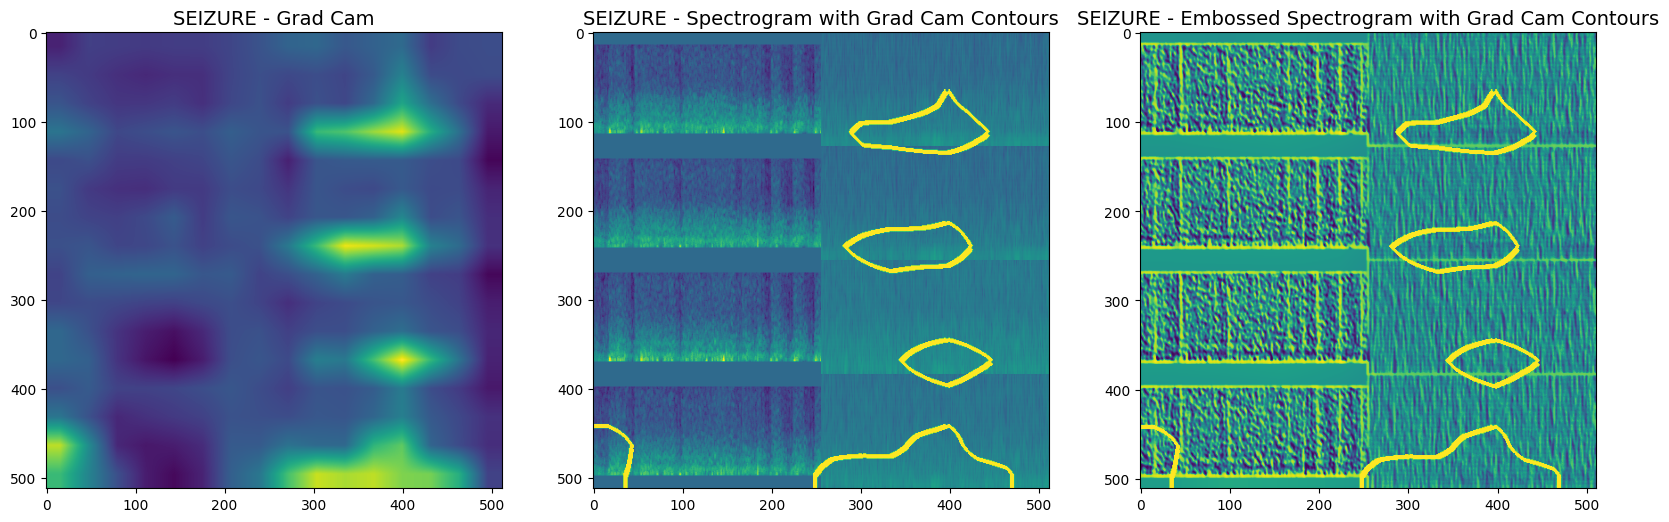


==> TRUE:  seizure=0.500 lpd=0.000 gpd=0.500 lrda=0.000 grda=0.000 other=0.000
==> PRED:  seizure=0.602 lpd=0.039 gpd=0.007 lrda=0.012 grda=0.017 other=0.322


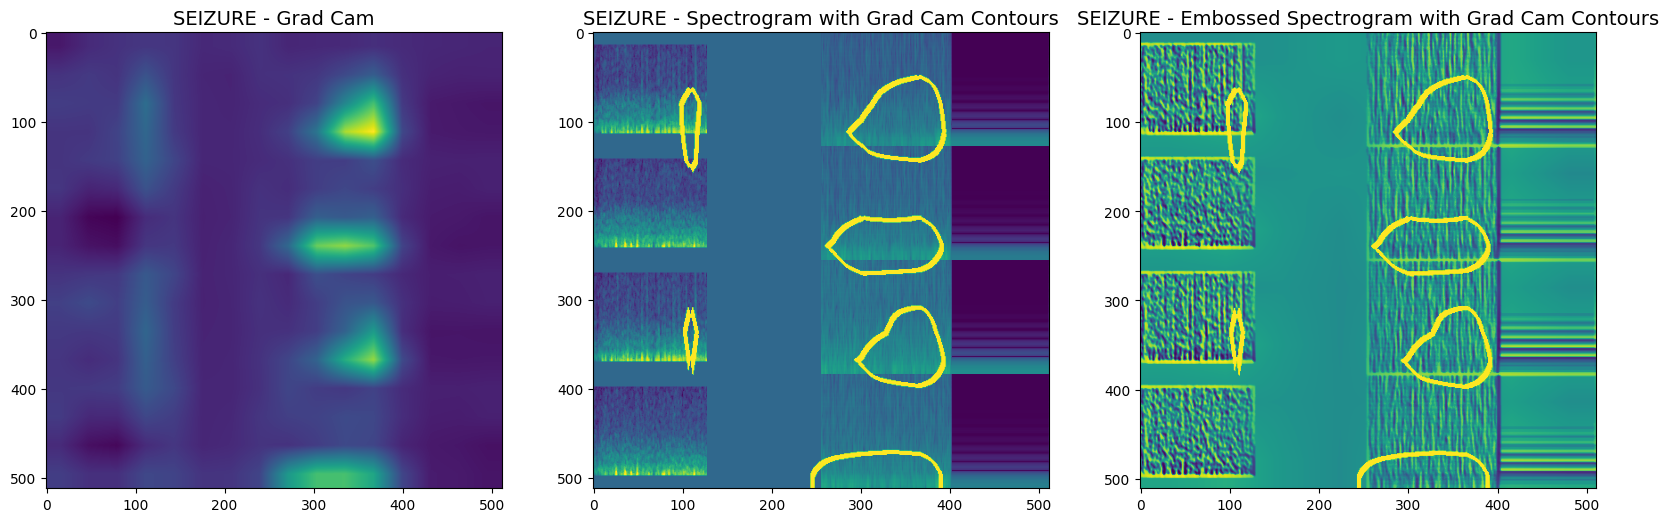


==> TRUE:  seizure=1.000 lpd=0.000 gpd=0.000 lrda=0.000 grda=0.000 other=0.000
==> PRED:  seizure=0.917 lpd=0.002 gpd=0.003 lrda=0.008 grda=0.007 other=0.063


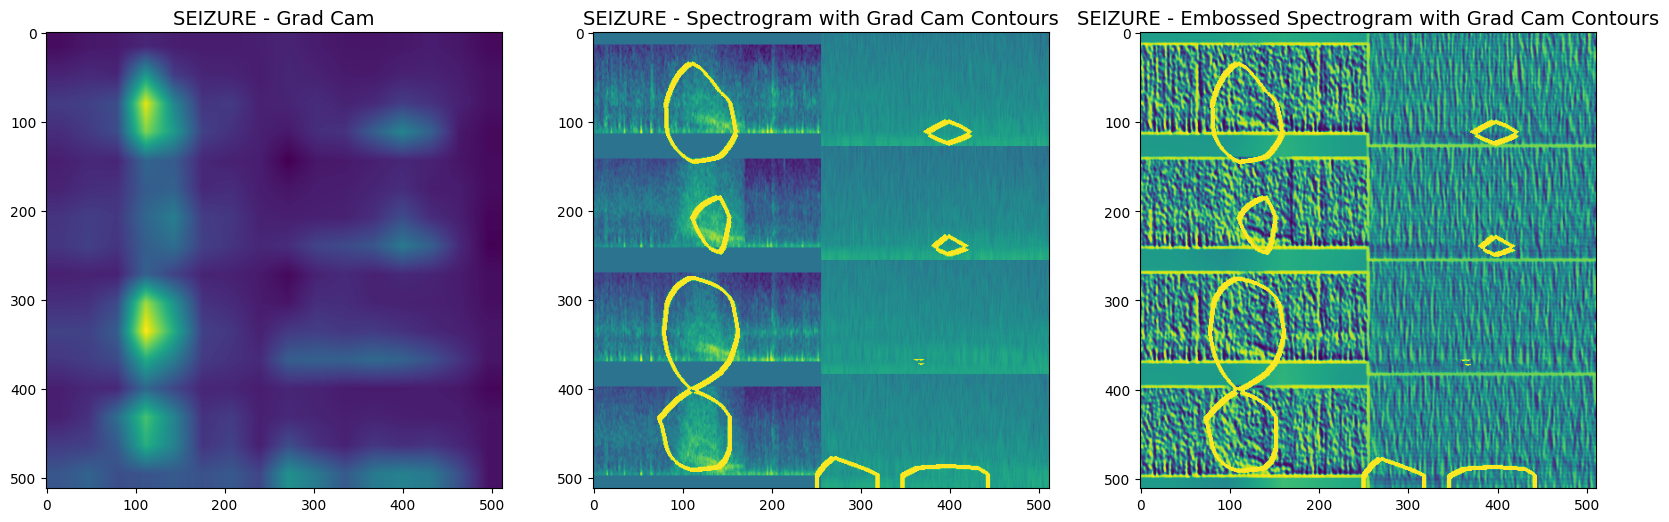


==> TRUE:  seizure=1.000 lpd=0.000 gpd=0.000 lrda=0.000 grda=0.000 other=0.000
==> PRED:  seizure=0.613 lpd=0.004 gpd=0.007 lrda=0.020 grda=0.058 other=0.297


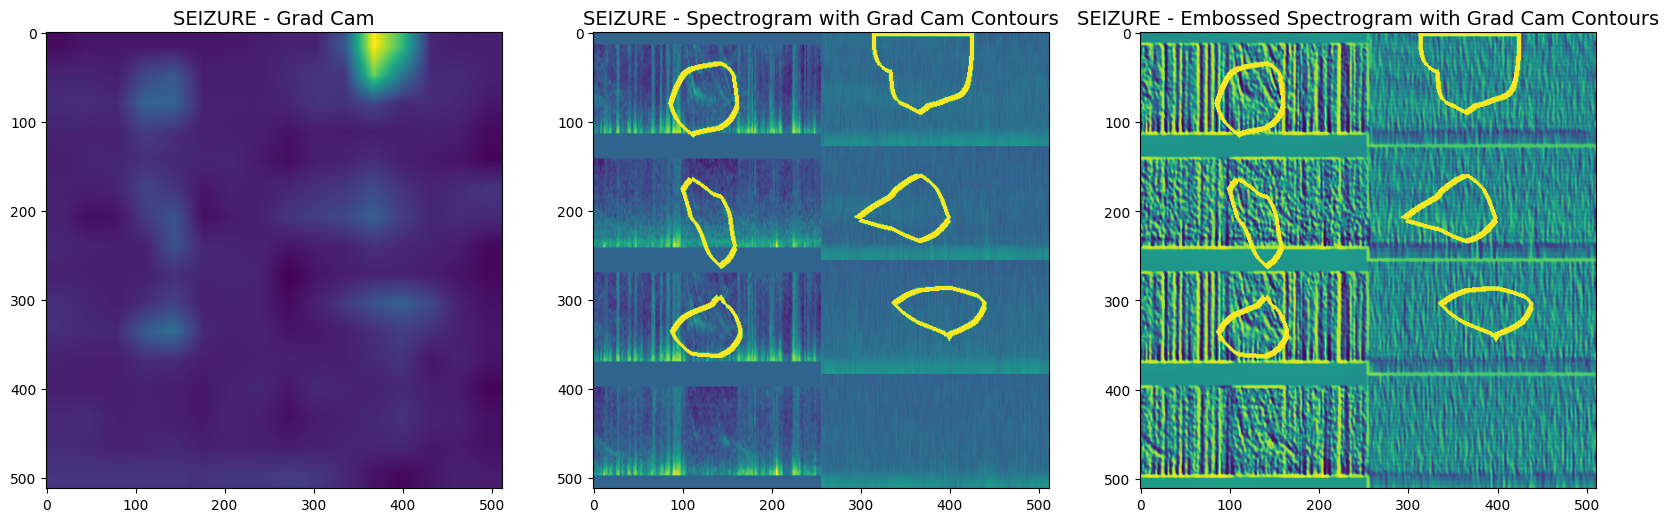


==> TRUE:  seizure=1.000 lpd=0.000 gpd=0.000 lrda=0.000 grda=0.000 other=0.000
==> PRED:  seizure=0.955 lpd=0.005 gpd=0.004 lrda=0.009 grda=0.007 other=0.019


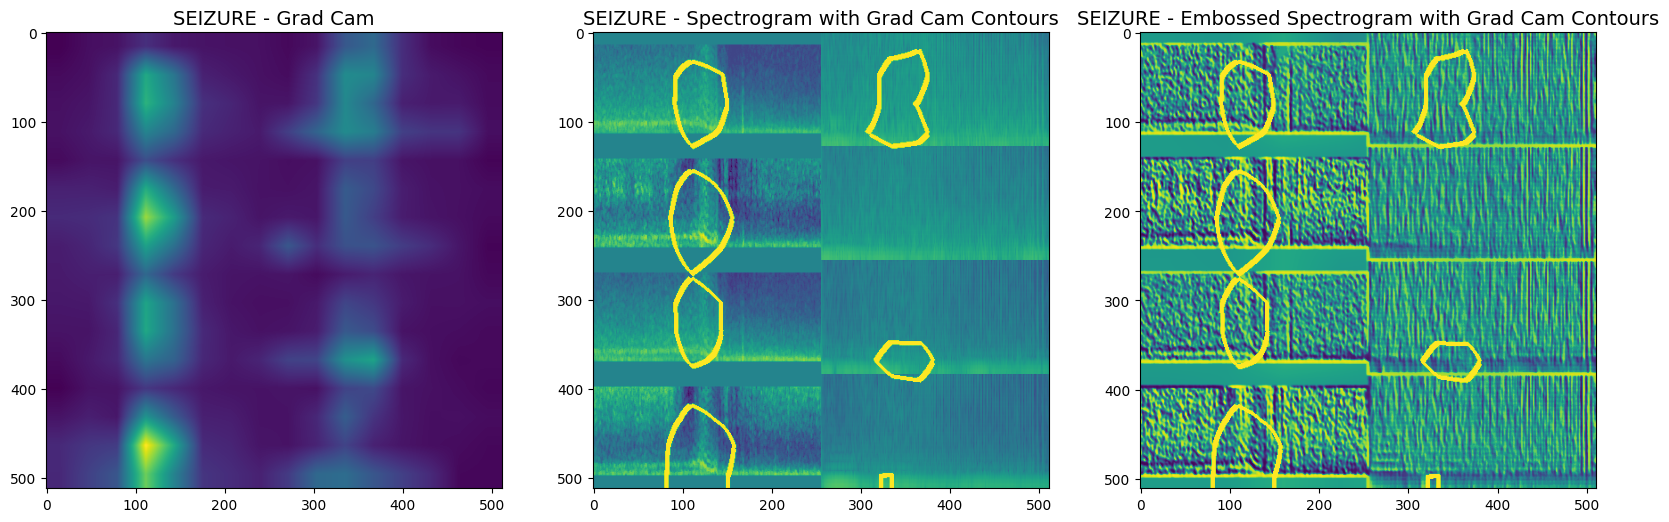


==> TRUE:  seizure=0.667 lpd=0.000 gpd=0.333 lrda=0.000 grda=0.000 other=0.000
==> PRED:  seizure=0.572 lpd=0.066 gpd=0.213 lrda=0.004 grda=0.007 other=0.138


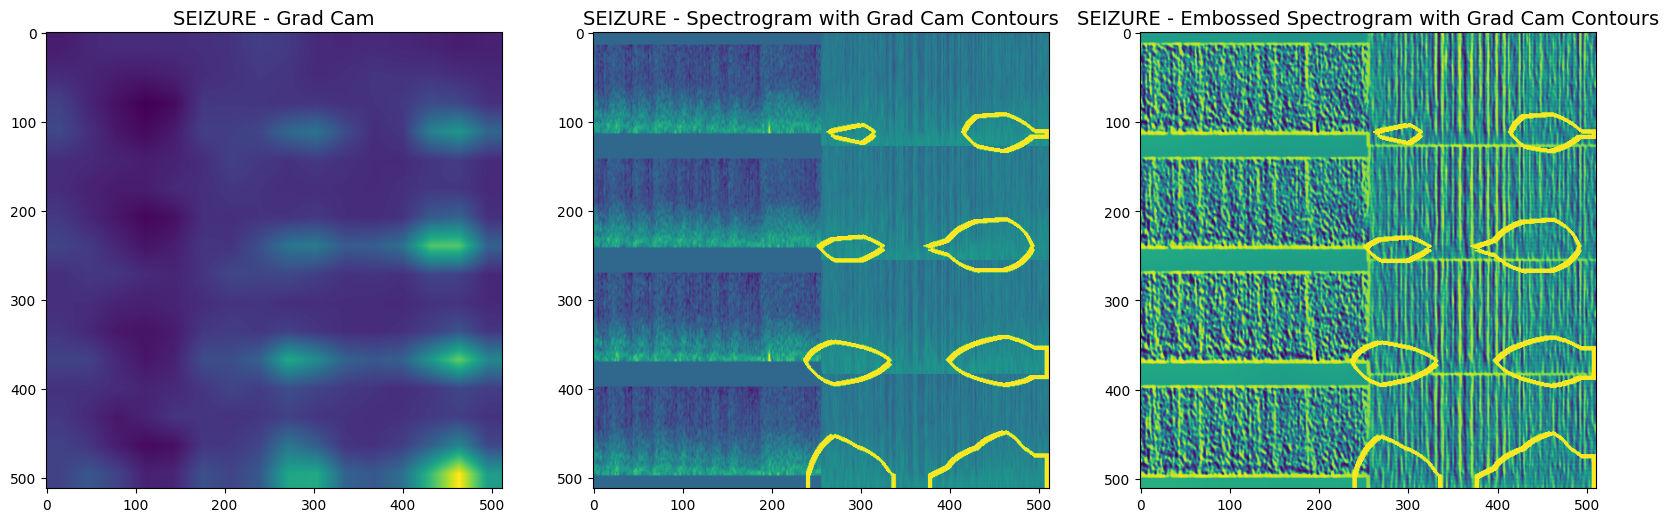


==> TRUE:  seizure=1.000 lpd=0.000 gpd=0.000 lrda=0.000 grda=0.000 other=0.000
==> PRED:  seizure=0.810 lpd=0.002 gpd=0.002 lrda=0.002 grda=0.006 other=0.178


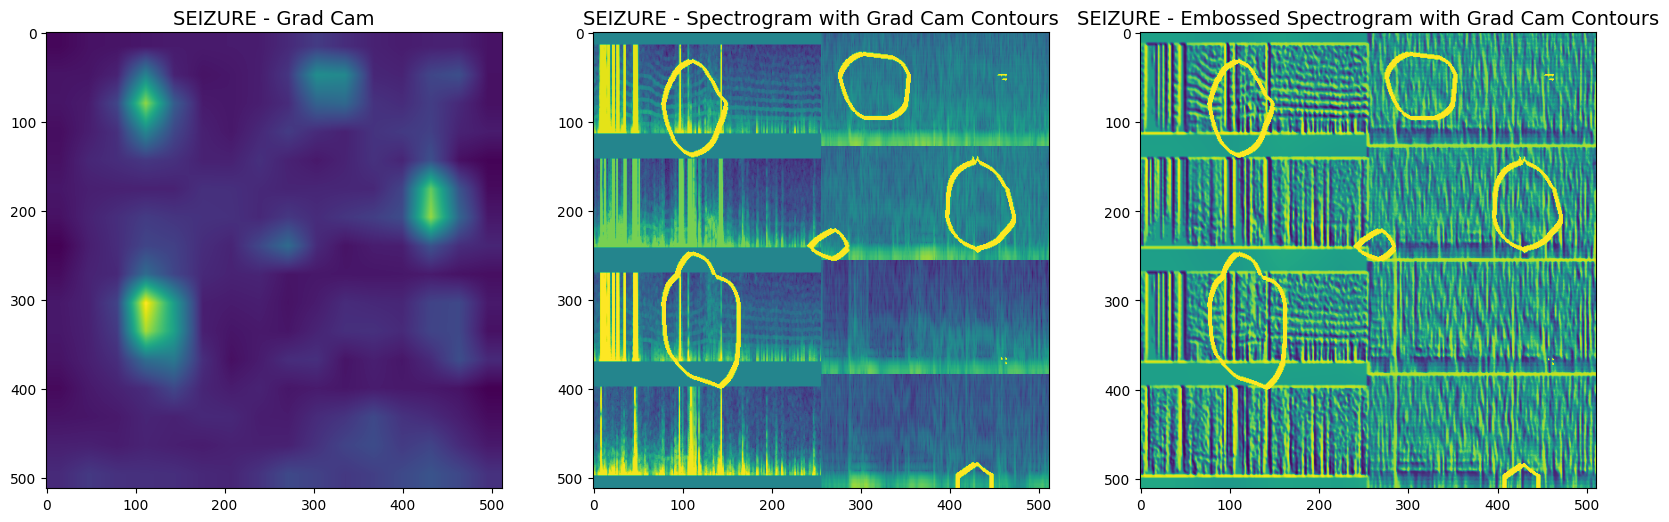


==> TRUE:  seizure=1.000 lpd=0.000 gpd=0.000 lrda=0.000 grda=0.000 other=0.000
==> PRED:  seizure=0.774 lpd=0.005 gpd=0.014 lrda=0.017 grda=0.032 other=0.158


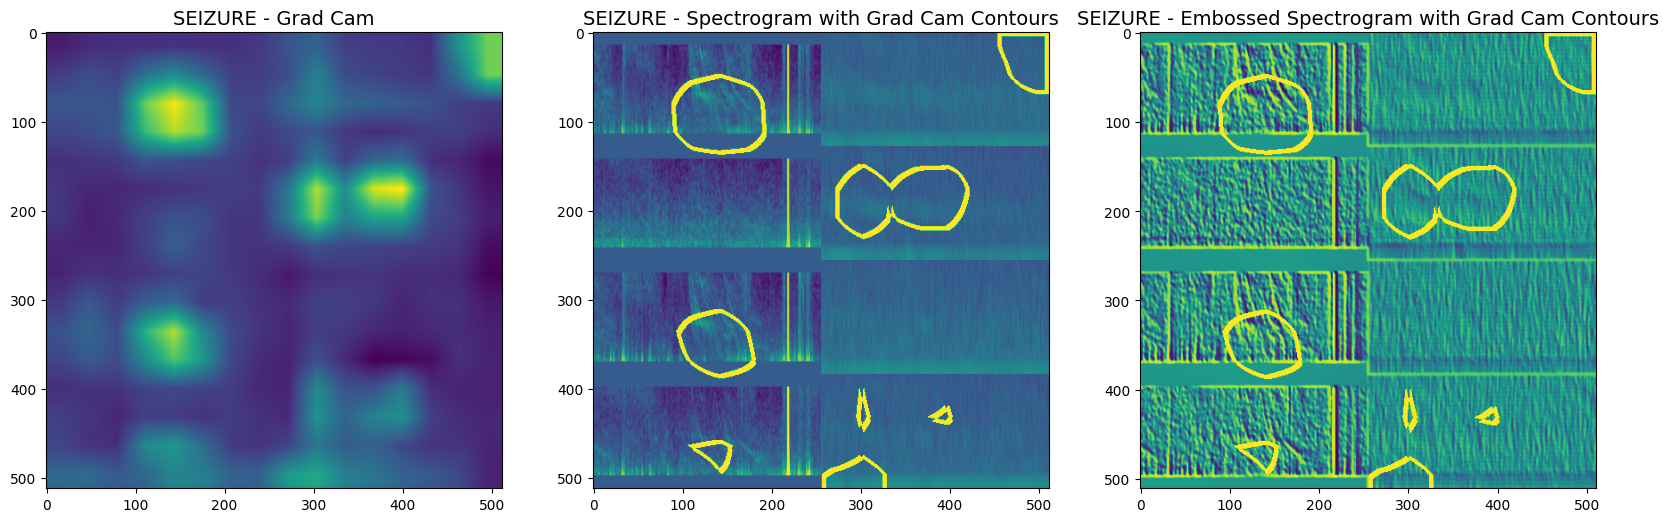


#########################
### LPD_VOTE
#########################
Found 347 samples in fold zero OOF for lpd_vote with true>0.5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [ ]:
BATCH = 128

for ii,tt in enumerate(TARGETS):
    ttt = tt.split('_')[0].upper()
    
    print()
    print('#'*25)
    print('###',tt.upper())
    print('#'*25)
    
    # FIND TRAIN SAMPLES IN OOF (OUT OF FOLD) WITH TARGET >= 0.5
    IDX = train.loc[train.index.isin(valid_index) & (train[tt]>=0.5),TARGETS].index.values
    print(f'Found {len(IDX)} samples in fold zero OOF for {tt} with true>0.5')
    
    # INFER TRAIN SAMPLES WITH MODEL (SAVE PREDS AND ACTIVATIONS)
    valid_gen = DataGenerator(train.iloc[IDX[:128]], shuffle=False, batch_size=BATCH, mode='valid')
    p,xx = model.predict(valid_gen,verbose=0)
    #print(xx.shape)
    
    # DISPLAY GRAD CAM
    for x,y in valid_gen:
        ct = 0
        for i in range(BATCH):
            
            # FIND SAMPLES WITH PRED >= 0.5 FOR TARGET
            if i>=len(p): continue
            pred = p[i]
            if pred[ii]<0.5: continue
                
            # FORMAT PREDICTIONS AS STRING
            pred2 = ''; true2 = ''
            true = train.loc[IDX[i]][TARGETS].values
            for j,t in enumerate(TARGETS):
                n = t.split('_')[0]
                pred2 += f' {n}={pred[j]:0.3f}'
                true2 += f' {n}={true[j]:0.3f}'
            print()
            print('==> TRUE:',true2)
            print('==> PRED:',pred2)

            # PLOT GRAD CAM RESULTS
            plt.figure(figsize=(20,8))

            # PLOT GRAD CAM IMAGE (PLOT 1 OF 3)
            plt.subplot(1,3,1)
            img = np.sum(xx[i,] * layer_weights,axis=-1)
            img = cv2.resize(img,(512,512))
            plt.imshow(img[::-1,])
            plt.title(f'{ttt} - Grad Cam',size=14)

            # FIND GRAD CAM CONTOURS FOR AREAS OF INTEREST
            cut = np.percentile(img.flatten(), [90])[0]
            cntr = img.copy()
            cntr[cntr>=cut] = 100
            cntr[cntr<cut] = 0
            cntr = mask2contour(cntr)

            # PLOT EMBOSSED SPECTROGRAMS WITH GRADCAM CONTOURS (PLOT 3 OF 3)
            plt.subplot(1,3,3)
            x1 = [x[i,:,:,k:k+1] for k in range(4)] #KAGGLE-SPECS: LL RL LP RP
            x1 = np.concatenate(x1,axis=0)  
            x2 = [x[i,:,:,k+4:k+5] for k in range(4)] #EEG-SPECS: LL LP RL RP
            x2 = np.concatenate(x2,axis=0)
            x3 = np.concatenate([x1,x2],axis=1)
            img = cv2.resize(x3,(512,512))
            img0 = img.copy()

            # EMBOSS IMAGE FOR IMAGE FEATURE VISIBILITY
            img = img[1:,1:] - img[:-1,:-1] #emboss
            img -= np.min(img)
            img /= np.max(img)
            img = (img*255).astype('uint8')
            img = cv2.GaussianBlur(img,(5,5),0)
            img = clahe.apply(img)
            mx = np.max(img)

            cntr2 = cntr[1:,1:]
            img[cntr2>0] = mx
            plt.imshow(img[::-1,])
            plt.title(f'{ttt} - Embossed Spectrogram with Grad Cam Contours',size=14)

            # PLOT SPECTROGRAMS WITH GRADCAM CONTOURS (PLOT 2 OF 3)
            plt.subplot(1,3,2)        
            mx = np.max(img0)
            img0[cntr>0] = mx
            plt.imshow(img0[::-1,])
            plt.title(f'{ttt} - Spectrogram with Grad Cam Contours',size=14)

            plt.show()
            ct += 1
            if ct==8: break

        break